In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import os

def get_masks(model_meta, model_dir,threshold):
    tf.reset_default_graph()

    with tf.Session() as sess:
        # load the checkpoint
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(model_meta)
        saver.restore(sess, model_dir)
        graph = tf.get_default_graph()
        all_vars = tf.trainable_variables()
        masks = {}
        for v in all_vars:
            # quantize only network variables
            mask_name = v.name
            v_numpy = sess.run(v)
            masks[mask_name] = (np.absolute(v_numpy)>threshold)
    return masks

def find_total_params(sess,all_vars):
    t_params=0
    for v in all_vars:
        #if ('fcn' in v.name) and ('Adam' not in v.name):
        v_numpy = sess.run(v)
        t_params += np.count_nonzero(v_numpy)
    
    return t_params
    
    
# one method to do pruning
def strategy_1(v_numpy,th):
    mask = (np.absolute(v_numpy)>th)
    v_numpy = np.multiply(v_numpy,mask)
    return v_numpy


def prune_one_variable(sess, v,th):
    v_numpy = sess.run(v)
    new_v = strategy_1(v_numpy,th)
    assign_op = v.assign(new_v)
    return assign_op

def prune_one_variable2(sess, v,mask):
    v_numpy = sess.run(v)
    new_v = np.multiply(v_numpy,mask)
    assign_op = v.assign(new_v)
    return assign_op

def prune_model(model_meta,model_dir,target_dir,threshold):
    tf.reset_default_graph()
    pruned_params = 0
    total_params = 0
    params_red = 0
    with tf.Session() as sess:
        # load the checkpoint
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(model_meta)
        saver.restore(sess, model_dir)
        graph = tf.get_default_graph()
        #all_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        all_vars = tf.trainable_variables()
        # find threshold
        total_params = find_total_params(sess,all_vars)
        #print(TOTAL_PARAMS)
        update_operation = []
        for v in all_vars:
            # prune only network variables
            #if ('fcn' in v.name) and ('Adam' not in v.name):
            update_operation.append(prune_one_variable(sess, v,threshold))
            #print(v.name)
        _ = sess.run(update_operation)

        pruned_params = find_total_params(sess,all_vars)
        #print(PRUNED_PARAMS)
        params_red = (1-(pruned_params/total_params))*100
        # save model
        saver.save(sess, target_dir)
    return total_params,pruned_params,params_red

def prune_model_retrain(model_meta,model_dir,target_dir,masks):
    tf.reset_default_graph()
    with tf.Session() as sess:
        # load the checkpoint
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(model_meta)
        saver.restore(sess, model_dir)
        graph = tf.get_default_graph()
        #all_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        all_vars = tf.trainable_variables()
        update_operation = []
        for v in all_vars:
            # prune only network variables
            #if ('fcn' in v.name) and ('Adam' not in v.name):
            mask_name = v.name
            mask = masks[v.name]
            #print(v.name)
            update_operation.append(prune_one_variable2(sess, v,mask))
            #print(v.name)
        _ = sess.run(update_operation)
        # save model
        saver.save(sess, target_dir)
        
def params_model(model_meta,model_dir):
    tf.reset_default_graph()
    params = {}
    total_params = 0
    with tf.Session() as sess:
        # load the checkpoint
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(model_meta)
        saver.restore(sess, model_dir)
        graph = tf.get_default_graph()
        all_vars = tf.trainable_variables()
        for v in all_vars:
            param_name = v.name
            v_numpy = sess.run(v)
            params[param_name]= np.count_nonzero(v_numpy)
        total_params = find_total_params(sess,all_vars)
    return total_params,params

def get_param_maxmin(model_meta,model_dir):
    tf.reset_default_graph()
    param_max = 0
    param_min = 0
    with tf.Session() as sess:
        # load the checkpoint
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(model_meta)
        saver.restore(sess, model_dir)
        graph = tf.get_default_graph()
        all_vars = tf.trainable_variables()
        j = 0
        for v in all_vars:
            param_name = v.name
            v_numpy = sess.run(v)
            pmax = np.amax(np.absolute(v_numpy))
            pmin = np.amin(np.absolute(v_numpy))
            if j==0:
                param_max = pmax
                param_min = pmin
            j = j+1
            if param_max<pmax:
                param_max = pmax
            if param_min > pmin:
                param_min = pmin
    return param_max, param_min

def params_in_range(model_meta,model_dir,min_range,max_range):
    tf.reset_default_graph()
    params = 0
    with tf.Session() as sess:
        # load the checkpoint
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(model_meta)
        saver.restore(sess, model_dir)
        graph = tf.get_default_graph()
        all_vars = tf.trainable_variables()
        j = 0
        for v in all_vars:
            v_numpy = sess.run(v)
            count = np.count_nonzero((v_numpy>=min_range)&(v_numpy<max_range))
            params += count
            
    return params

def get_all_params(model_meta,model_dir):
    tf.reset_default_graph()
    params = []
    with tf.Session() as sess:
        # load the checkpoint
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(model_meta)
        saver.restore(sess, model_dir)
        graph = tf.get_default_graph()
        all_vars = tf.trainable_variables()
        for v in all_vars:
            v_numpy = sess.run(v)
            params.append(v_numpy.flatten())
            
        params_t = np.hstack(params)
            
    return params_t
            
    

In [2]:
model_dir = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt"
model_meta = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt.meta"
param_max, param_min = get_param_maxmin(model_meta,model_dir)

print('Maximum absolute parameter: {} and minimum absolute parameter: {}'.format(param_max,param_min))

INFO:tensorflow:Restoring parameters from C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt
Maximum absolute parameter: 0.07237327098846436 and minimum absolute parameter: 1.4431407180381939e-09


In [3]:
import matplotlib.pyplot as plt
model_dir = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt"
model_meta = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt.meta"
params = get_all_params(model_meta,model_dir)
print(params.shape)

INFO:tensorflow:Restoring parameters from C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt
(18906351,)


In [4]:
total_params, _ = params_model(model_meta,model_dir)
print(total_params)

INFO:tensorflow:Restoring parameters from C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt
18906351


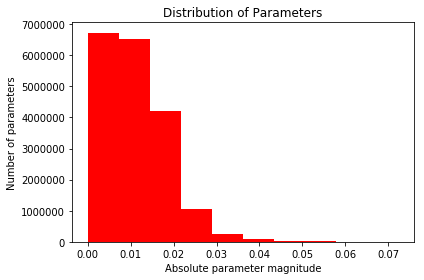

In [5]:
fig = plt.figure()
n, bins, patches = plt.hist(np.absolute(params), bins = 10, facecolor='r')
plt.xlabel('Absolute parameter magnitude')
plt.ylabel('Number of parameters')
plt.title('Distribution of Parameters')
fig.tight_layout()
#fig.savefig('parameter_distribution.png')
plt.show()

In [6]:
THRESHOLD = 0.005
model_dir = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt"
model_meta = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt.meta"
target_dir = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model4\model.ckpt"
TOTAL_PARAMS,PRUNED_PARAMS,PARAMS_REDUCTION = prune_model(model_meta,model_dir,target_dir,THRESHOLD)

print('Total parameters: {}, Parameters after pruning: {} , Reduction in parameters: {} %'.format(TOTAL_PARAMS,PRUNED_PARAMS,PARAMS_REDUCTION))

INFO:tensorflow:Restoring parameters from C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model4\model.ckpt
Total parameters: 18906351, Parameters after pruning: 14242141 , Reduction in parameters: 24.670069861709433 %


In [7]:
# get masks
MASKS= get_masks(model_meta, model_dir,THRESHOLD)

INFO:tensorflow:Restoring parameters from C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\saved_model2\model.ckpt


In [8]:
# Retrain pruned model

import tensorflow as tf
import sys
import random
import time

import labelreg.helpers as helper
import labelreg.networks as network
import labelreg.utils as util
import labelreg.losses as loss

mod_dir = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model_retrain2\model.ckpt"

tf.reset_default_graph()
# 0 - get configs
config = helper.ConfigParser(sys.argv, 'training')

# 1 - data
reader_moving_image, reader_fixed_image, reader_moving_label, reader_fixed_label = helper.get_data_readers(
    config['Data']['dir_moving_image'],
    config['Data']['dir_fixed_image'],
    config['Data']['dir_moving_label'],
    config['Data']['dir_fixed_label'])


# 2 - graph

ph_moving_image = tf.placeholder(tf.float32, [config['Train']['minibatch_size']]+reader_moving_image.data_shape+[1])
ph_fixed_image = tf.placeholder(tf.float32, [config['Train']['minibatch_size']]+reader_fixed_image.data_shape+[1])
ph_moving_affine = tf.placeholder(tf.float32, [config['Train']['minibatch_size']]+[1, 12])
ph_fixed_affine = tf.placeholder(tf.float32, [config['Train']['minibatch_size']]+[1, 12])
input_moving_image = util.warp_image_affine(ph_moving_image, ph_moving_affine)  # data augmentation
input_fixed_image = util.warp_image_affine(ph_fixed_image, ph_fixed_affine)  # data augmentation

# predicting ddf
reg_net = network.build_network(network_type=config['Network']['network_type'],
                                minibatch_size=config['Train']['minibatch_size'],
                                image_moving=input_moving_image,
                                image_fixed=input_fixed_image)

# loss
ph_moving_label = tf.placeholder(tf.float32, [config['Train']['minibatch_size']]+reader_moving_image.data_shape+[1])
ph_fixed_label = tf.placeholder(tf.float32, [config['Train']['minibatch_size']]+reader_fixed_image.data_shape+[1])
input_moving_label = util.warp_image_affine(ph_moving_label, ph_moving_affine)  # data augmentation
input_fixed_label = util.warp_image_affine(ph_fixed_label, ph_fixed_affine)  # data augmentation

warped_moving_label = reg_net.warp_image(input_moving_label)  # warp the moving label with the predicted ddf

loss_similarity, loss_regulariser = loss.build_loss(similarity_type=config['Loss']['similarity_type'],
                                                    similarity_scales=config['Loss']['similarity_scales'],
                                                    regulariser_type=config['Loss']['regulariser_type'],
                                                    regulariser_weight=config['Loss']['regulariser_weight'],
                                                    label_moving=warped_moving_label,
                                                    label_fixed=input_fixed_label,
                                                    network_type=config['Network']['network_type'],
                                                    ddf=reg_net.ddf)

opt = tf.train.AdamOptimizer(config['Train']['learning_rate'])

# utility nodes - for information only
dice = util.compute_binary_dice(warped_moving_label, input_fixed_label)
dist = util.compute_centroid_distance(warped_moving_label, input_fixed_label)

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train_gradient = opt.compute_gradients(loss_similarity+loss_regulariser)
    pruned_train_gradient = [[tf.multiply(v[0], tf.convert_to_tensor(np.array(MASKS[v[1].name],dtype=np.float32))), v[1]] for v in train_gradient]
    train_op = opt.apply_gradients(pruned_train_gradient)

# 3 - training
num_minibatch = int(reader_moving_label.num_data/config['Train']['minibatch_size'])
train_indices = [i for i in range(reader_moving_label.num_data)]
test_labels = [1,12,18,19,23]

saver = tf.train.Saver(max_to_keep=1)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.restore(sess, mod_dir)
for step in range(config['Train']['total_iterations']):

    if step in range(0, config['Train']['total_iterations'], num_minibatch):
        random.shuffle(train_indices)

    minibatch_idx = step % num_minibatch
    case_indices = train_indices[
                    minibatch_idx*config['Train']['minibatch_size']:(minibatch_idx+1)*config['Train']['minibatch_size']]
    #print(case_indices)
    label_indices = [test_labels[random.randint(0,4)] for i in case_indices]
    #print(label_indices)

    trainFeed = {ph_moving_image: reader_moving_image.get_data(case_indices),
                 ph_fixed_image: reader_fixed_image.get_data(case_indices),
                 ph_moving_label: reader_moving_label.get_data(case_indices, label_indices),
                 ph_fixed_label: reader_fixed_label.get_data(case_indices, label_indices),
                 ph_moving_affine: helper.random_transform_generator(config['Train']['minibatch_size']),
                 ph_fixed_affine: helper.random_transform_generator(config['Train']['minibatch_size'])}

    sess.run(train_op, feed_dict=trainFeed)

    if step in range(0, config['Train']['total_iterations'], config['Train']['freq_info_print']):
        current_time = time.asctime(time.gmtime())
        loss_similarity_train, loss_regulariser_train, dice_train, dist_train = sess.run(
            [loss_similarity,
             loss_regulariser,
             dice,
             dist],
            feed_dict=trainFeed)

        # print('----- Training -----')
        print('Step %d [%s]: Loss=%f (similarity=%f, regulariser=%f)' %
              (step,
               current_time,
               loss_similarity_train+loss_regulariser_train,
               1-loss_similarity_train,
               loss_regulariser_train))
        print('  Dice: %s' % dice_train)
        print('  Distance: %s' % dist_train)
        print('  Image-label indices: %s - %s' % (case_indices, label_indices))

    if step in range(0, config['Train']['total_iterations'], config['Train']['freq_model_save']):
        save_path = saver.save(sess, config['Train']['file_model_save'])
        print("Model saved in: %s" % save_path)
        
all_vars = tf.trainable_variables()
update_operation = []
for v in all_vars:
    # prune only network variables
    #if ('fcn' in v.name) and ('Adam' not in v.name):
    mask_name = v.name
    mask = MASKS[v.name]
    #print(v.name)
    update_operation.append(prune_one_variable2(sess, v,mask))
    #print(v.name)
_ = sess.run(update_operation)
save_path = saver.save(sess, config['Train']['file_model_save'])
print("Model saved in: %s" % save_path)


Reading default config file in: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\config_demo.ini.

[Data]: dir_moving_image: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\train\moving_images
[Data]: dir_fixed_image: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\train\fixed_images
[Data]: dir_moving_label: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\train\moving_labels
[Data]: dir_fixed_label: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\train\fixed_labels
[Network]: network_type: local
[Loss]: similarity_type: dice
[Loss]: similarity_scales: [0, 1, 2, 4, 8, 16]
[Loss]: regulariser_type: bending
[Loss]: regulariser_weight: 0.5
[Train]: total_iterations: 150
[Train]: learning_rate: 0.0001
[Train]: minibatch_siz

Step 125 [Thu Mar 28 07:21:34 2019]: Loss=0.763386 (similarity=0.240471, regulariser=0.003857)
  Dice: [0.68401486 0.51731604 0.7218935  0.45613274]
  Distance: [0.9699757  1.614966   0.83378273 2.2678509 ]
  Image-label indices: [48, 59, 87, 80] - [23, 23, 12, 19]
Step 130 [Thu Mar 28 07:24:32 2019]: Loss=0.744871 (similarity=0.259189, regulariser=0.004060)
  Dice: [0.6979038  0.5470561  0.5229612  0.46283287]
  Distance: [0.959328  3.2689536 2.640828  2.5879476]
  Image-label indices: [140, 117, 26, 137] - [23, 23, 18, 19]
Step 135 [Thu Mar 28 07:27:28 2019]: Loss=0.773282 (similarity=0.230576, regulariser=0.003858)
  Dice: [0.46827015 0.596145   0.37883958 0.7161017 ]
  Distance: [2.2861843 1.647342  3.7851913 1.284647 ]
  Image-label indices: [63, 118, 39, 24] - [1, 19, 12, 12]
Step 140 [Thu Mar 28 07:30:29 2019]: Loss=0.764109 (similarity=0.240552, regulariser=0.004661)
  Dice: [0.4846803  0.3473054  0.51653767 0.7899902 ]
  Distance: [2.7080176 3.4455326 2.5466573 0.9516625]
  Im

In [7]:
# INference of pruned model without retraining
import tensorflow as tf
import sys

import labelreg.helpers as helper
import labelreg.networks as network
import labelreg.apps as app

tf.reset_default_graph()

# 0 - get configs
config = helper.ConfigParser(sys.argv, 'inference')

# 1 - images to register
reader_moving_image, reader_fixed_image, _, _ = helper.get_data_readers(config['Inference']['dir_moving_image'],
                                                                        config['Inference']['dir_fixed_image'])

# 2 - graph
# network for predicting ddf only
ph_moving_image = tf.placeholder(tf.float32, [reader_moving_image.num_data]+reader_moving_image.data_shape+[1])
ph_fixed_image = tf.placeholder(tf.float32, [reader_fixed_image.num_data]+reader_fixed_image.data_shape+[1])

reg_net = network.build_network(network_type=config['Network']['network_type'],
                                minibatch_size=reader_moving_image.num_data,
                                image_moving=ph_moving_image,
                                image_fixed=ph_fixed_image)

# restore the trained weights
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, config['Inference']['file_model_saved'])


# 3 - compute ddf
testFeed = {ph_moving_image: reader_moving_image.get_data(),
            ph_fixed_image: reader_fixed_image.get_data()}
ddf = sess.run(reg_net.ddf, feed_dict=testFeed)
helper.write_images(ddf, config['Inference']['dir_save'], 'ddf')

# warp the test images
warped_images = app.warp_volumes_by_ddf(reader_moving_image.get_data(), ddf)
helper.write_images(warped_images, config['Inference']['dir_save'], 'warped_image')

# warp test labels of gland segmentation, i.e. label_indices=0
if config['Inference']['dir_moving_label']:
    data_moving_label = helper.DataReader(config['Inference']['dir_moving_label'],labelr=True).get_data(label_indices=[1])
    warped_labels = app.warp_volumes_by_ddf(data_moving_label, ddf)
    helper.write_images(warped_labels, config['Inference']['dir_save'], 'warped_label')


Reading default config file in: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\config_demo.ini.

[Network]: network_type: local
[Inference]: file_model_saved: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model4\model.ckpt
[Inference]: dir_moving_image: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\test\moving_images
[Inference]: dir_fixed_image: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\test\fixed_images
[Inference]: dir_save: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\inference_results\Pruned4_results
[Inference]: dir_moving_label: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\test\moving_labels
[Inference]: dir_fixed_label: C:\Users

In [9]:
# INference of pruned model after retraining
import tensorflow as tf
import sys

import labelreg.helpers as helper
import labelreg.networks as network
import labelreg.apps as app


tf.reset_default_graph()
# 0 - get configs
config = helper.ConfigParser(sys.argv, 'inference')

# 1 - images to register
reader_moving_image, reader_fixed_image, _, _ = helper.get_data_readers(config['Inference']['dir_moving_image'],
                                                                        config['Inference']['dir_fixed_image'])

# 2 - graph
# network for predicting ddf only
ph_moving_image = tf.placeholder(tf.float32, [reader_moving_image.num_data]+reader_moving_image.data_shape+[1])
ph_fixed_image = tf.placeholder(tf.float32, [reader_fixed_image.num_data]+reader_fixed_image.data_shape+[1])

reg_net = network.build_network(network_type=config['Network']['network_type'],
                                minibatch_size=reader_moving_image.num_data,
                                image_moving=ph_moving_image,
                                image_fixed=ph_fixed_image)

# restore the trained weights
saver = tf.train.Saver()
sess = tf.Session()
saver.restore(sess, config['Inference']['file_model_saved'])


# 3 - compute ddf
testFeed = {ph_moving_image: reader_moving_image.get_data(),
            ph_fixed_image: reader_fixed_image.get_data()}
ddf = sess.run(reg_net.ddf, feed_dict=testFeed)
helper.write_images(ddf, config['Inference']['dir_save'], 'ddf')

# warp the test images
warped_images = app.warp_volumes_by_ddf(reader_moving_image.get_data(), ddf)
helper.write_images(warped_images, config['Inference']['dir_save'], 'warped_image')

# warp test labels of gland segmentation, i.e. label_indices=0
if config['Inference']['dir_moving_label']:
    data_moving_label = helper.DataReader(config['Inference']['dir_moving_label'],labelr=True).get_data(label_indices=[1])
    warped_labels = app.warp_volumes_by_ddf(data_moving_label, ddf)
    helper.write_images(warped_labels, config['Inference']['dir_save'], 'warped_label')


Reading default config file in: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\config_demo.ini.

[Network]: network_type: local
[Inference]: file_model_saved: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model_retrain2\model.ckpt
[Inference]: dir_moving_image: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\test\moving_images
[Inference]: dir_fixed_image: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\test\fixed_images
[Inference]: dir_save: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\inference_results\Pruned_retrain2_results
[Inference]: dir_moving_label: C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\test\moving_labels
[Inference]: dir_fixed

In [10]:
import matplotlib.pyplot as plt
model_dir = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model2\pruned_model2.ckpt"
model_meta = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model2\pruned_model2.ckpt.meta"
total_params, _ = params_model(model_meta,model_dir)
print(total_params)

INFO:tensorflow:Restoring parameters from C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model2\pruned_model2.ckpt
14237634


In [11]:
model_dir = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model_retrain2\model.ckpt"
model_meta = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model_retrain2\model.ckpt.meta"
total_params, _ = params_model(model_meta,model_dir)
print(total_params)

INFO:tensorflow:Restoring parameters from C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model_retrain2\model.ckpt
14237634


In [8]:
model_dir = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model3\pruned_model3.ckpt"
model_meta = r"C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model3\pruned_model3.ckpt.meta"
total_params, _ = params_model(model_meta,model_dir)
print(total_params)

INFO:tensorflow:Restoring parameters from C:\Users\rahul\OneDrive\Desktop\Courses\ECE209as\Final Project\label-reg-master\labelreg\ibsr v2\data_final\pruned_model3\pruned_model3.ckpt
14238584
